# PROCESAMIENTO DE LENGUAJE NATURAL

## Trabajo Practico 3
## Gustavo Uñapillco            a1624

## Consigna del desafío 3

Utilizar otro dataset y poner en práctica la generación de secuencias con las estrategias presentadas.

# DESARROLLO

## Instalación de librerías e imports

In [2]:
# Instalar el paquete sin mostrar la salida
#!pip install datasets > /dev/null 2>&1
#!pip install --upgrade datasets > /dev/null 2>&1
#!pip install kaggle > /dev/null 2>&1
!pip install nltk > /dev/null 2>&1
!pip3 install torchinfo > /dev/null 2>&1

In [41]:
# Librerías de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary  # Utilizamos torchinfo como fork de torchsummar


# Librerías de TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# Librerías de procesamiento de datos
import sys
import numpy as np
import pandas as pd
import random
import io
import pickle
import re
import os
import platform
import zipfile


# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de procesamiento de texto (NLTK)
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descargar recursos de nltk si no los tienes
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Librerías de datasets
#from datasets import load_dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

from torch_helpers import categorical_acc

--2024-11-28 00:25:22--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2024-11-28 00:25:22--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0s      

2024-11-28 00:25:22 (151 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2024-11-28 00:25:22--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0s (151 MB/s)


## 1. Carga y Exploración del dataset


Para armar nuestro dataset usamos el libro "The Adventures of Sherlock Holmes" y lo descargamos desde Gutenberg.

URL: https://www.gutenberg.org/files/1661/1661-0.txt

In [5]:
import os
import urllib.request

# Ruta donde se descargará el archivo de texto
book_url = 'https://www.gutenberg.org/files/1661/1661-0.txt'  # URL de "The Adventures of Sherlock Holmes"
#book_url = 'https://www.gutenberg.org/files/11/11-0.txt'     # URL libro más ligero "Alice’s Adventures in Wonderland" by Lewis Carroll

book_filename = 'libro.txt'  # Nombre del archivo que se descargará
book_dir = '/content'  # Directorio donde se guardará el archivo

# Verificar si el archivo ya está descargado
if not os.path.exists(book_filename):
    print("El archivo no está descargado, descargando ahora...")
    # Descargar el libro de Project Gutenberg
    urllib.request.urlretrieve(book_url, book_filename)
else:
    print("El archivo ya está descargado.")

# Verificar si el directorio existe
if not os.path.exists(book_dir):
    print("Creando directorio para almacenar el archivo...")
    os.makedirs(book_dir)

# Mover el archivo descargado al directorio
if os.path.exists(book_filename):
    os.rename(book_filename, os.path.join(book_dir, book_filename))
    print(f"El archivo ha sido movido a: {os.path.join(book_dir, book_filename)}")

# Verificar el tamaño del archivo descargado
file_size = os.path.getsize(os.path.join(book_dir, book_filename))
print(f"Tamaño del archivo descargado: {file_size / (1024 * 1024):.2f} MB")

El archivo no está descargado, descargando ahora...
El archivo ha sido movido a: /content/libro.txt
Tamaño del archivo descargado: 0.58 MB


Armamos el dataset

In [6]:
# Tomamos el documento libro.txt y armamos el dataset utilizando salto de línea para separar las oraciones/docs
df=pd.read_csv('libro.txt', sep='/n', header=None)
df.head()

<ipython-input-6-bbcf7d9216d7>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv('libro.txt', sep='/n', header=None)


,0
0,The Project Gutenberg eBook of The Adventures ...
1,by Arthur Conan Doyle
2,This eBook is for the use of anyone anywhere i...
3,most other parts of the world at no cost and w...
4,"whatsoever. You may copy it, give it away or r..."


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 9629


## 2. Preprocesamiento

In [8]:
# Primeras filas del dataset
df.loc[:20,0]

,0
0,The Project Gutenberg eBook of The Adventures ...
1,by Arthur Conan Doyle
2,This eBook is for the use of anyone anywhere i...
3,most other parts of the world at no cost and w...
4,"whatsoever. You may copy it, give it away or r..."
5,of the Project Gutenberg License included with...
6,www.gutenberg.org. If you are not located in t...
7,will have to check the laws of the country whe...
8,using this eBook.
9,Title: The Adventures of Sherlock Holmes


Decido eliminar las 18 primeras filas ya que no tiene relación con el contenido del libro si no con la plataforma Gutenberg.

In [9]:
# Eliminar las primeras 18 filas
df = df.iloc[18:]

# Reiniciar los índices del dataset para que sean consecutivos
df.reset_index(drop=True, inplace=True)

In [10]:
# Ahora las primeras filas son:
df.loc[:20,0]

,0
0,The Adventures of Sherlock Holmes
1,by Arthur Conan Doyle
2,Contents
3,I. A Scandal in Bohemia
4,II. The Red-Headed League
5,III. A Case of Identity
6,IV. The Boscombe Valley Mystery
7,V. The Five Orange Pips
8,VI. The Man with the Twisted Lip
9,VII. The Adventure of the Blue Carbuncle


### 2.1. Armado de Corpus  y conversión de Corpus a Tokens

Armamos el corpus con todas las filas

In [ ]:
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

Corpus a token

In [12]:
tokens=text_to_word_sequence(corpus)
tokens[:20]

['the',
 'adventures',
 'of',
 'sherlock',
 'holmes',
 'by',
 'arthur',
 'conan',
 'doyle',
 'contents',
 'i',
 'a',
 'scandal',
 'in',
 'bohemia',
 'ii',
 'the',
 'red',
 'headed',
 'league']

In [13]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 111002


### 2.2. Desfazaje de palabras

In [14]:
train_len=10

In [15]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [16]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:5]

[['the',
  'adventures',
  'of',
  'sherlock',
  'holmes',
  'by',
  'arthur',
  'conan',
  'doyle',
  'contents'],
 ['adventures',
  'of',
  'sherlock',
  'holmes',
  'by',
  'arthur',
  'conan',
  'doyle',
  'contents',
  'i'],
 ['of',
  'sherlock',
  'holmes',
  'by',
  'arthur',
  'conan',
  'doyle',
  'contents',
  'i',
  'a'],
 ['sherlock',
  'holmes',
  'by',
  'arthur',
  'conan',
  'doyle',
  'contents',
  'i',
  'a',
  'scandal'],
 ['holmes',
  'by',
  'arthur',
  'conan',
  'doyle',
  'contents',
  'i',
  'a',
  'scandal',
  'in']]

### 2.3. Tokenización

In [17]:
# Proceso de tokenizacion
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [18]:
# Damos un vistazo
sequences[:20]

[[1, 1670, 4, 133, 34, 46, 772, 8907, 8905, 1922],
 [1670, 4, 133, 34, 46, 772, 8907, 8905, 1922, 6],
 [4, 133, 34, 46, 772, 8907, 8905, 1922, 6, 5],
 [133, 34, 46, 772, 8907, 8905, 1922, 6, 5, 884],
 [34, 46, 772, 8907, 8905, 1922, 6, 5, 884, 8],
 [46, 772, 8907, 8905, 1922, 6, 5, 884, 8, 940],
 [772, 8907, 8905, 1922, 6, 5, 884, 8, 940, 2657],
 [8907, 8905, 1922, 6, 5, 884, 8, 940, 2657, 1],
 [8905, 1922, 6, 5, 884, 8, 940, 2657, 1, 246],
 [1922, 6, 5, 884, 8, 940, 2657, 1, 246, 481],
 [6, 5, 884, 8, 940, 2657, 1, 246, 481, 690],
 [5, 884, 8, 940, 2657, 1, 246, 481, 690, 2658],
 [884, 8, 940, 2657, 1, 246, 481, 690, 2658, 5],
 [8, 940, 2657, 1, 246, 481, 690, 2658, 5, 113],
 [940, 2657, 1, 246, 481, 690, 2658, 5, 113, 4],
 [2657, 1, 246, 481, 690, 2658, 5, 113, 4, 2234],
 [1, 246, 481, 690, 2658, 5, 113, 4, 2234, 3392],
 [246, 481, 690, 2658, 5, 113, 4, 2234, 3392, 1],
 [481, 690, 2658, 5, 113, 4, 2234, 3392, 1, 773],
 [690, 2658, 5, 113, 4, 2234, 3392, 1, 773, 1465]]

In [19]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 110992


## 3. Input y target

In [20]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]

print('x_data.shape:', x_data.shape)
print('y_data.shape:', y_data_int.shape)

x_data.shape: (110992, 9)
y_data.shape: (110992,)


In [21]:
# Palabras del vocabulario
vocab_size = len(tok.index_word)
print(vocab_size)

8908


In [22]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

## 4. Procesamiento de Input y Target para entrenamiento

In [23]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores.
        # Convertir los datos a torch.int64 para ser compatibles con nn.Embedding
        self.x = torch.from_numpy(x.astype(np.int64))  # Cambiado a int64 (LongTensor)
        self.y = torch.from_numpy(y.astype(np.int64))

        self.len = self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [24]:
#Creo el dataset
data_set = Data(x_data, y_data_int_offset)

# Tamaño de la entrada (largo de las secuencias de entrada)
input_size = data_set.x.shape[1]
print("input_size:", input_size)

# Tamaño de la salida (cantidad de clases)
output_dim = vocab_size  # Directamente igual al número de clases
print("Output dim:", output_dim)


input_size: 9
Output dim: 8908


In [25]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 88794
Tamaño del conjunto de validacion: 22198


## 5.  Entrenar el modelo

In [26]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 5.1. Arquitectura de Modelo

In [27]:
class Model2(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=50, padding_idx=0)  # Embedding más grande
        self.lstm1 = nn.LSTM(input_size=50, hidden_size=self.lstm_size, batch_first=True, num_layers=self.num_layers, dropout=0.2)
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32)  # Capa completamente conectada
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim)  # Capa completamente conectada

        self.relu = nn.LeakyReLU(negative_slope=0.01)  # Usar LeakyReLU
        self.dropout = nn.Dropout(0.5)  # Regularización con dropout adicional

    def forward(self, x, prev_state=None):
        batch_size = x.shape[0]

        # Si no hay estado previo, inicializa el estado oculto
        if prev_state is None:
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:, -1, :]))  # Tomamos la última salida de la secuencia
        out = self.dropout(out)  # Aplico dropout
        out = self.fc2(out)  # La capa final sin softmax
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))

# Asegúrate de inicializar los pesos correctamente
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)

### 5.3. Instanciado de modelo

In [36]:
model2 = Model2(vocab_size=vocab_size, output_dim=output_dim)
model2.apply(init_weights)
if cuda: model2.cuda()

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
model2_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

input_data = data_set[0][0].unsqueeze(0).long().to(device)
summary(model2, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 8908]                 --
├─Embedding: 1-1                         [1, 9, 50]                445,450
├─LSTM: 1-2                              [1, 9, 64]                62,976
├─Linear: 1-3                            [1, 32]                   2,080
├─LeakyReLU: 1-4                         [1, 32]                   --
├─Dropout: 1-5                           [1, 32]                   --
├─Linear: 1-6                            [1, 8908]                 293,964
Total params: 804,470
Trainable params: 804,470
Non-trainable params: 0
Total mult-adds (M): 1.31
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 3.22
Estimated Total Size (MB): 3.30

### 5.4. Función de entrenamiento

In [38]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    def calculate_accuracy(y_pred, y_true):
        # Predicción de la clase con la mayor probabilidad
        _, predicted = torch.max(y_pred, dim=1)

        # Comparar con las etiquetas verdaderas
        correct = (predicted == y_true).float()
        accuracy = correct.sum() / correct.size(0)  # Promedio de aciertos
        return accuracy

    print("Modelo a entrenar:\n\t", model)
    print("Optimizador: \n\t",optimizer)
    print("Criterion:\n\t ", criterion)


    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            optimizer.zero_grad()

            output = model(train_data.to(device)).cpu()

            # Asegúrate de que las etiquetas sean un vector de enteros
            train_target = train_target.squeeze()  # Elimina cualquier dimensión de tamaño 1

            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Calcular precisión del batch sin categorical_acc
            accuracy = calculate_accuracy(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss /= len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy /= len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realiza validación
        model.eval()
        with torch.no_grad():
            for valid_data, valid_target in valid_loader:
                output = model(valid_data.to(device)).cpu()

                # Asegúrate de que las etiquetas sean un vector de enteros
                valid_target = valid_target.squeeze()  # Elimina cualquier dimensión de tamaño 1

                epoch_valid_loss = criterion(output, valid_target).item()
                valid_loss.append(epoch_valid_loss)

                # Calcular precisión del batch sin categorical_acc
                epoch_valid_accuracy = calculate_accuracy(output, valid_target).item()
                valid_accuracy.append(epoch_valid_accuracy)


        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }

    return history

### 5.5. Entrenamiento y resultados

In [39]:
history = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=100

                  )


Modelo a entrenar:
	 Model2(
  (embedding): Embedding(8909, 50, padding_idx=0)
  (lstm1): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8908, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
)
Optimizador: 
	 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion:
	  CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1/100 - Train loss 6.701 - Train accuracy 0.052 - Valid Loss 6.762 - Valid accuracy 0.048
Epoch: 2/100 - Train loss 6.451 - Train accuracy 0.058 - Valid Loss 6.785 - Valid accuracy 0.059
Epoch: 3/100 - Train loss 6.306 - Train accuracy 0.069 - Valid Loss 6.757 - Valid accuracy 0.073
Epoch: 4/100 - Train loss 6.148 - Train accuracy 0.081 - Valid Loss 6.739 - Valid accuracy 0.083
Epoch: 5/100 - Train loss 6.018 - Train accuracy 0.088 - Valid Loss 6.784 - Valid accuracy 0.086
Epoch: 6/100 - Train loss 5.909 - Train accuracy 0.092 - Valid Loss 6.846 - Valid accuracy 0.093
Epoch: 7/100 - Train loss 5.817 - Train accuracy 0.096 - Valid Loss 6.916 - Valid accuracy 0.093
Epoch: 8/100 - Train loss 5.744 - Train accuracy 0.098 - Valid Loss 7.015 - Valid accuracy 0.096
Epoch: 9/100 - Train loss 5.677 - Train accuracy 0.101 - Valid Loss 7.071 - Valid accuracy 0.098
Epoch: 10/100 - Train loss 5.621 - Train accuracy 0.105 - Valid Loss 7.018 - Valid accuracy 0.097
Epoch: 11/100 - Train loss 5.

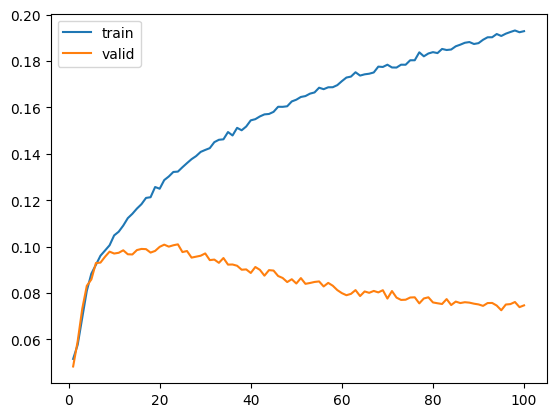

In [42]:
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

El gráfico muestra que, aunque la precisión en el conjunto de entrenamiento mejora con las épocas, la precisión en el conjunto de validación se mantiene estancada o empeora ligeramente. Esto indica que no hay sobreajuste (overfitting), ya que, en ese caso, veríamos una mejora en el entrenamiento acompañada de una caída en la validación. En cambio, parece que el modelo está subajustado (underfitting), lo que significa que no está aprendiendo eficazmente de los datos.

## 6. Predicción de próxima palabra

In [43]:
import sys
!{sys.executable} -m pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 14.6 MB/s eta 0:00:00


In [48]:
import gradio as gr
import torch
import numpy as np

import torch

# Verifica si CUDA está disponible y selecciona el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def model_response(human_text):
    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Transformo a tensor y muevo al dispositivo correcto
    tensor = torch.from_numpy(encoded.astype(np.int32)).to(device)

    # Predicción softmax
    y_hat = model2(tensor).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra que corresponde al índice predicho por el modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=gr.Textbox(),  # Usamos gr.Textbox para el input
    outputs="text"  # Salida de texto
)

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://61458b5453c71c20af.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://61458b5453c71c20af.gradio.live


## 7. Generación de secuencias nuevas

In [53]:
import torch
import numpy as np
from keras.preprocessing.sequence import pad_sequences

def generate_seq(model, tokenizer, seed_text, max_length, n_words, device):
    """
    Ejecuta la predicción de secuencias con el modelo

    Args:
        model (torch model): Modelo entrenado en PyTorch
        tokenizer (keras tokenizer): Tokenizer utilizado en el preprocesamiento
        seed_text (string): Texto de entrada (input_seq)
        max_length (int): Máxima longitud de la secuencia de entrada
        n_words (int): Número de palabras a agregar a la secuencia
        device (torch.device): Dispositivo (CPU o GPU) donde se encuentra el modelo
    returns:
        output_text (string): Sentencia con las "n_words" agregadas
    """
    output_text = seed_text
    # Genera un número fijo de palabras
    for _ in range(n_words):
        # Encodeamos el texto de entrada
        encoded = tokenizer.texts_to_sequences([output_text])[0]
        # Si tienen distinto largo, ajustamos
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Convertimos el encoded a un tensor y lo movemos al dispositivo
        tensor = torch.from_numpy(encoded.astype(np.int32)).to(device)

        # Predicción softmax
        y_hat = model(tensor)  # Predicción de PyTorch
        y_hat = y_hat.argmax(dim=-1).item()  # Seleccionamos el índice de la palabra más probable

        # Buscamos la palabra correspondiente al índice predicho
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

        # Agregamos la palabra predicha a la secuencia
        output_text += ' ' + out_word

    return output_text

In [60]:
input_text=' I have seldom heard\'t'

generate_seq(model2, tok, input_text, max_length=3, n_words=4, device=device)



" I have seldom heard't ’ this morning with"

In [61]:
generate_seq(model2, tok, 'A Scandal in Bohemia', max_length=3, n_words=4, device=device)


'A Scandal in Bohemia the when the when'

## 6. Conclusiones

A continuación, le comparto algunas conclusiones basadas en los resultados de los múltiples entrenamientos que he realizado:


1. Bajo rendimiento en accuracy (precisión):
    
    A lo largo de todo el entrenamiento, la accuracy, tanto en el conjunto de entrenamiento como en el de validación, se mantuvo extremadamente baja, rondando entre el 5% y el 20%. Estos valores están muy por debajo de lo que se esperaría para un modelo bien entrenado en una tarea de clasificación multi-clase.


2. Poca mejora durante el entrenamiento:

    A pesar de haber entrenado durante 100 épocas, no se observó una mejora significativa. La pérdida en el conjunto de entrenamiento disminuyó ligeramente (de 6.701 a 4.623), pero esto no se tradujo en una mejora notable en la precisión, ni en el conjunto de entrenamiento ni en el de validación. Esto podría sugerir que el modelo está estancado o que el proceso de aprendizaje no está siendo efectivo.


3. Posible underfitting:

    No he detectado un sobreajuste claro, ya que la precisión de validación sigue siendo baja y no mejora durante el entrenamiento. Sin embargo, esto también puede ser un indicio de que el modelo no está aprendiendo adecuadamente, lo que podría apuntar a un subajuste.


4. Embeddings personalizados no están funcionando como esperaba:

    Al utilizar embeddings personalizados, me parece que no están representando de forma óptima las relaciones semánticas dentro de los datos. Esto podría estar limitando la capacidad del modelo para aprender patrones útiles de manera efectiva.


5. Exploración insuficiente del espacio de características:
    
    La falta de mejora en la precisión sugiere que el modelo no está explorando correctamente el espacio de características de los datos. Esto puede estar relacionado con un modelo demasiado simple, con un número insuficiente de capas o neuronas, o con la elección de hiperparámetros no adecuados.


6. Algunas recomendaciones para mi mismo:

    * Ajuste de hiperparámetros: Considero que sería útil realizar más ajustes en el tamaño de los embeddings, el número de capas LSTM o la tasa de aprendizaje del optimizador. También podría probar con optimizadores diferentes, como RMSprop o SGD con momentum.

    * Regularización: Podría ser beneficioso agregar técnicas de regularización L2 (además del dropout ya aplicado), para evitar que el modelo se quede atrapado en un punto de optimización subóptimo.

    * Entrenamiento más largo: Si los hiperparámetros se ajustan adecuadamente y el modelo sigue sin mejorar, podría ser útil entrenar durante más épocas o probar con técnicas de ajuste fino.

He realizado pruebas utilizando embeddings preentrenados, pero lamentablemente, siempre generan problemas de rendimiento en Colab debido al alto uso de CPU, lo que interrumpe el proceso. A pesar de estos intentos, la precisión sigue siendo muy baja, lo que indica que el modelo tiene dificultades para aprender adecuadamente de los datos y no está generalizando correctamente. Esto sugiere que es necesario ajustar tanto los hiperparámetros como posiblemente la arquitectura del modelo. Lamentablemente, no cuento con más recursos ni tiempo para seguir realizando más pruebas en este momento.